ML ШИФТ

[JINT] (SHIFT-64009) Пашина Алёна

# Описание задачи

Чтобы попасть в здание, нужно пройти через турникет. Чтобы открыть парковку, нужно открыть шлагбаум. Чтобы попасть на этаж, нужно приложить 'таблетку'. Все это фиксируется - кто, в какую дату, в какое время.
Сможем ли мы выучить, кому конкретно принадлежит 'след' прохода через турникеты? Мы знаем, что это был кто-то, кто уже был. (Правда, есть и несколько новых - не больше 10%).

'8 утра понедельник, турникет 4? Директор.' '11 утра суббота? Гриша. Но Гриша в последний день месяца никогда не приходит.'  Какие есть паттерны в настоящих данных?

**Цель** - предсказать, кто вошел в здание по времени и турникету.

**Описание данных**

В обучающей выборке:

* `user_id` - ID посетителя
* `ts` - дата и время прохождения через турникет
* `gate_id` - ID турникета

В тестовой выборке `user_id` заменены на слова: `aucroc, binary, blue, categorical` и т.п.

Требуется составить таблицу вида:

| user_word | preds |
| --- | --- |
| aucroc | 50 |
| binary | 11 |
| blue | -999 |
| ... | ... |

* `user_word` - закодированные ID пользователей
* `preds` - предсказанные ID
* `-999` - ID нового посетителя, которого раньше не было

Таблицу нужно запомнить как `csv` и потом заархивировать в `zip` архив. 

Каждому слову сопоставлен вес, который зависит от того, насколько трудно предсказать ID. Баллы набираются как взвешенная по весам сумма правильных ответов. Чем сложнее отгадали слово, тем больше баллов.

Посетителей здания будем считать сотрудниками некой компании.

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import sklearn
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (roc_auc_score, 
                             f1_score,
                             roc_curve, 
                             accuracy_score, 
                             ConfusionMatrixDisplay, 
                             confusion_matrix, 
                             recall_score,
                             precision_score)
from sklearn.inspection import permutation_importance
from catboost import (CatBoostClassifier,
                        Pool,
                        EShapCalcType,
                        EFeaturesSelectionAlgorithm)

import shap
import loguru
import plotly
import phik
import zipfile
import io
import re
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution
import optuna
from scipy.stats import mode

In [2]:
# sklearn.set_config(transform_output="pandas")
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

RANDOM_STATE = 42

In [3]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

# Первичный анализ и предобработка данных

In [4]:
df_train = pd.read_csv('../data/train.csv', index_col=[0], parse_dates=[2])
df_test = pd.read_csv('../data/test.csv', index_col=[0], parse_dates=[1])
ex_submit = pd.read_csv('../data/submit.csv')

In [5]:
for name, df in zip(['тренировочная выборка', 'тестовая выборка', 'пример решения'], [df_train, df_test, ex_submit]):
    print(f'\033[1m{name}:\033[0m')
    display(df)
    print(f'\033[1mобщая информация - {name}:\033[0m')
    df.info()
    print(f'\033[1mколичество пропусков: {df.isna().sum().sum()}\033[0m')
    print(f'\033[1mколичество явных дубликатов: {df.duplicated().sum()}\033[0m')
    print()

тренировочная выборка:


,user_id,ts,gate_id
0,18,2022-07-29 09:08:54,7
1,18,2022-07-29 09:09:54,9
2,18,2022-07-29 09:09:54,9
3,18,2022-07-29 09:10:06,5
4,18,2022-07-29 09:10:08,5
...,...,...,...
37513,6,2022-12-31 20:38:56,11
37514,6,2022-12-31 20:39:22,6
37515,6,2022-12-31 20:39:23,6
37516,6,2022-12-31 20:39:31,9


общая информация - тренировочная выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 37518 entries, 0 to 37517
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   user_id  37518 non-null  int64         
 1   ts       37518 non-null  datetime64[ns]
 2   gate_id  37518 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB
количество пропусков: 0
количество явных дубликатов: 2346

тестовая выборка:


,ts,gate_id,user_word
37518,2023-01-03 08:21:00,9,gini
37519,2023-01-03 08:21:00,9,gini
37520,2023-01-03 08:21:18,5,gini
37521,2023-01-03 08:21:19,5,gini
37522,2023-01-03 08:21:39,10,gini
...,...,...,...
44638,2023-02-24 19:43:36,11,collinear
44639,2023-02-24 19:44:00,4,collinear
44640,2023-02-24 19:44:01,4,collinear
44641,2023-02-24 19:44:09,9,collinear


общая информация - тестовая выборка:
<class 'pandas.core.frame.DataFrame'>
Index: 7125 entries, 37518 to 44642
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ts         7125 non-null   datetime64[ns]
 1   gate_id    7125 non-null   int64         
 2   user_word  7125 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 222.7+ KB
количество пропусков: 0
количество явных дубликатов: 505

пример решения:


,user_word,preds
0,aucroc,49
1,binary,12
2,blue,55
3,categorical,14
4,coefficient,15
5,collinear,12
6,distributed,12
7,epsilon,1
8,f1,37
9,fit,3


общая информация - пример решения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_word  34 non-null     object
 1   preds      34 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes
количество пропусков: 0
количество явных дубликатов: 0



Пропусков в данных не обнаружено.

В тренировочной и тестовой выборке есть явные дубликаты, удалим их.

In [6]:
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)

In [7]:
df_train.shape

(35172, 3)

In [8]:
df_test.shape

(6620, 3)

In [9]:
df_train.ts.agg([min, max]).to_frame()

,ts
min,2022-07-29 09:08:54
max,2022-12-31 20:39:31


In [10]:
df_test.ts.agg([min, max]).to_frame()

,ts
min,2023-01-03 08:21:00
max,2023-02-24 19:44:09


In [11]:
(df_test.ts.max() - df_train.ts.min()).days // 30

7

Предоставлены данные за 7 месяцев - с июля 2022 по фефраль 2023. Номер месяца в качестве признака не подойдет.

ID сотрудников

In [12]:
# id сотрудников в train
print(*sorted(df_train.user_id.unique()), sep=', ')
print(f'Количество сотрудников в train: {len(df_train.user_id.unique())}')

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57
Количество сотрудников в train: 56


In [13]:
# отсутствующие id
set(range(0, 58)) - set(df_train.user_id.unique())

{13, 16}

In [14]:
# активность сотрудников в train
count_user_id = df_train.user_id.value_counts(ascending=True).to_frame()

In [15]:
count_user_id.T

user_id,4,51,44,21,52,30,5,38,10,8,2,36,7,45,28,22,41,20,43,56,31,25,40,23,34,26,42,24,46,57,27,35,14,17,48,3,29,50,54,9,32,39,49,1,0,33,47,11,53,18,15,19,12,6,55,37
count,1,2,4,5,5,10,10,13,17,27,39,45,48,57,64,87,110,112,117,129,181,238,242,247,267,279,340,386,475,482,523,549,617,648,712,894,924,965,977,1015,1020,1032,1129,1171,1184,1184,1250,1255,1279,1441,1659,1661,1837,1857,2166,2184


In [16]:
# delete_user_id = [4, 5, 7, 8, 10, 18, 20, 21, 22, 27, 28, 30, 31, 34, 36, 38, 40, 41, 42, 44, 45, 47, 48, 51, 52, 53, 57]

In [17]:
# 8 и 41

In [18]:
# delete_user_id = [4, 5, 7, 8, 10, 18, 20, 21, 27, 28, 30, 31, 34, 38, 40, 41, 42, 44, 45, 47, 48, 51, 52, 53, 57]
# len(delete_user_id)

In [19]:
# delete_user_id = [4, 5, 7, 8, 10, 18, 20, 21, 27, 28, 30, 31, 34, 38, 40, 41, 42, 44, 45, 47, 48, 51, 52, 53, 57]
# len(delete_user_id)

In [20]:
# delete_user_id = [2, 4, 5, 7, 8, 10, 21, 22, 28, 30, 36, 38, 44, 45, 51, 52]
# len(delete_user_id)

In [21]:
delete_user_id = [4, 5, 7, 10, 21, 28, 30, 38, 44, 45, 51, 52] + [18, 20, 31, 40, 42, 57] + [47, 48, 53]
len(delete_user_id)

21

In [22]:
len(df_train.user_id.unique()) - len(delete_user_id)

35

In [23]:
df_train = df_train[~df_train['user_id'].isin(delete_user_id)]
df_train.shape

(28897, 3)

In [24]:
print(f'Количество сотрудников в train: {len(df_train.user_id.unique())}')

Количество сотрудников в train: 35


In [25]:
df_train.user_id.value_counts(ascending=True).to_frame()

,count
user_id,
8,27
2,39
36,45
22,87
41,110
43,117
56,129
25,238
23,247


Исходя из графиков посещений здания для каждого сотрудника, исключим некоторых из тренировочной выборки.

In [26]:
print(f'Количество сотрудников в test: {len(df_test.user_word.unique())}')

Количество сотрудников в test: 34


In [27]:
# по условию сказано, что в тестовой выборке может быть не более 10% новых сотрудников
int(.1 * len(df_test.user_word.unique()))

3

In [28]:
# активность сотрудников в test
count_user_word = df_test.user_word.value_counts(ascending=True).to_frame()

In [29]:
count_user_word.T

user_word,logistic,blue,lasso,aucroc,regression,y,precision,coefficient,minimization,mse,target,distributed,ols,tstat,ridge,matrix,pvalue,fit,r2,linear,predict,recall,residual,categorical,gini,significant,independent,collinear,x,epsilon,binary,sigmoid,loss,f1
count,5,12,33,37,50,50,54,56,95,103,111,117,139,139,141,157,181,183,185,199,208,210,224,245,253,277,278,298,298,336,362,432,458,694


Турникеты

In [30]:
print(f'Количество турникетов в train: {len(df_train.gate_id.unique())}')
# частота использования турникетов в train
count_gate_id_train = df_train.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_train.T

Количество турникетов в train: 17


gate_id,14,0,16,1,8,-1,15,12,13,6,9,7,11,5,10,3,4
count,1,2,3,5,21,23,298,388,746,1397,1541,2475,3442,3884,4001,4112,6558


In [31]:
print(f'Количество турникетов в test: {len(df_test.gate_id.unique())}')
# частота использования турникетов в test
count_gate_id_test = df_test.gate_id.value_counts(ascending=True).to_frame()
count_gate_id_test.T

Количество турникетов в test: 16


gate_id,14,-1,1,2,8,15,12,6,13,9,7,11,5,3,10,4
count,1,1,2,4,10,102,120,282,310,394,540,762,853,893,915,1431


In [32]:
# id турникетов, которые есть в train, но нет в test
set(df_train.gate_id.unique()) - set(df_test.gate_id.unique())

{0, 16}

In [33]:
# id турникетов, которые есть в test, но нет в train
set(df_test.gate_id.unique()) - set(df_train.gate_id.unique())

{2}

Поскольку `gate_id` мы будем использовать в качестве признака, редкие категории (менее 5 записей) нужно удалить.

In [34]:
delete_gate_id = set(count_gate_id_train.query('count < 5').index) | set(count_gate_id_test.query('count < 5').index)
delete_gate_id

{-1, 0, 1, 2, 14, 16}

In [35]:
df_train = df_train.query('gate_id not in @delete_gate_id').reset_index(drop=True)
df_test = df_test.query('gate_id not in @delete_gate_id').reset_index(drop=True)

In [36]:
df_test.shape

(6612, 3)

# Генерирование признаков

In [37]:
def make_features(df):
    df = df.loc[:]
    # отсортируем датафрейм для удобства генерирования признаков
    # потом отсортируем только по дате
    df = df.sort_values(['user_id', 'ts']).reset_index(drop=True)
    # временные признаки
    df['date'] = df.ts.dt.normalize()
    df['day_of_month'] = df.ts.dt.day
    df['hour'] = df.ts.dt.hour
    df['total_minutes'] = df.hour * 60 + df.ts.dt.minute
    df['total_seconds'] = df.total_minutes * 60 + df.ts.dt.second
    df['week_number'] = df.ts.dt.isocalendar().week             # неделя начинается с пн. Вспомогательный признак
    df['day_of_week'] = df.ts.dt.dayofweek                      # 0 = пн.
    df['is_weekend'] = df.day_of_week >= 5
    df['time_of_day'] = np.select(
            condlist=[df['hour'] < 6, df['hour'] < 12, df['hour'] < 18],
            choicelist=['night', 'morning', 'afternoon'],
            default='evening',
    )       # время суток
    df['is_month_start'] = df['ts'].dt.is_month_start
    df['is_month_end'] = df['ts'].dt.is_month_end

    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # число проходов сотрудником ч/з турникуты в день
    df['pass_cnt_per_day'] = grouped_data['gate_id'].transform('size')
    # число проходов через конкретный турникет в конкретный день
    df['daily_gate_pass_count'] = df.groupby(['user_id', 'date', 'gate_id'])['gate_id'].transform('size')
    # вероятность прохода через конкретный турникет в конкретный день
    df['probability_gate_id'] = df['daily_gate_pass_count'] / df['pass_cnt_per_day']
    # количество сотрудников, вошедших в конкретный день в здание
    df['cnt_users_per_day'] = df.groupby('date')['user_id'].transform('nunique')
    # количество сотрудников, вошедших в конкретную неделю в здание
    df['cnt_users_per_week'] = df.groupby('week_number')['user_id'].transform('nunique')
    # индекс дневной явки сотрудника
    df['daily_attendance_index'] = df['cnt_users_per_day'] / df['cnt_users_per_week']
    # количество дней в конкретную неделю, в которые сотрудник заходил в здание
    df['cnt_days_per_week'] = df.groupby(['user_id', 'week_number'])['date'].transform('nunique')

    # количество уникальных турникетов, через которые прошел сотрудник за день
    df['nunique_gate_per_day'] = grouped_data['gate_id'].transform('nunique')
    # количество уникальных турникетов, через которые прошел сотрудник за неделю
    df['nunique_gate_per_week'] = df.groupby(['user_id', 'week_number'])['gate_id'].transform('nunique')


    # время прихода на работу (количество минут от полуночи)
    df['entry_time'] = grouped_data['ts'].transform('min')
    df['entry_time'] = ((df['entry_time'] - df['date']).dt.total_seconds() // 60).astype('int')
    # время ухода с работы (количество минут от полуночи)
    df['exit_time'] = grouped_data['ts'].transform('max')
    df['exit_time'] = ((df['exit_time'] - df['date']).dt.total_seconds() // 60).astype('int')   # Вспомогательный признак
    # продолжительность рабочего времени в минутах
    df['working_time_per_day'] = df['exit_time'] - df['entry_time']
    # турникет, через который сотрудник зашел в здание в конкретный день
    df['entrance_gate_id'] = grouped_data['gate_id'].transform('first')
    # турникет, через который сотрудник вышел из здания в конкретный день
    df['exit_gate_id'] = grouped_data['gate_id'].transform('last')
    # продолжительность рабочего времени за неделю в минутах (working_time_per_week)
    df_working_time_per_week = df.groupby(['user_id', 'date'], as_index=False)[['week_number', 'working_time_per_day']].first()
    df_working_time_per_week = df_working_time_per_week.groupby(['user_id', 'week_number'], as_index=False)['working_time_per_day'].sum()
    df_working_time_per_week = df_working_time_per_week.rename(columns={'working_time_per_day': 'working_time_per_week'})
    df = pd.merge(df, df_working_time_per_week, on=['user_id', 'week_number'], how='left')
    # индекс дневной нагрузки сотрудника - отношение минут работы за день к минутам работы за неделю
    df['daily_workload_index'] = df['working_time_per_day'] / df['working_time_per_week']
    # на случай, когда working_time_per_day = 0 и working_time_per_week = 0
    df['daily_workload_index'] = df['daily_workload_index'].fillna(0)

    for i in range(1, 6):
        # 5 предыдущих турникетов
        df[f'gate_id_lag_{i}'] = grouped_data['gate_id'].shift(i, fill_value=-100)
        # 5 последующих турникетов
        df[f'gate_id_{i}'] = grouped_data['gate_id'].shift(-i, fill_value=-200)
        # разница в секундах между текущей записью и пятью предыдущими
        df[f'sec_btw_lag_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(i)
        df[f'sec_btw_lag_{i}'] = df[f'sec_btw_lag_{i}'].fillna(-1000).astype('int')
        # разница в секундах между текущей записью и пятью следующими
        df[f'sec_btw_{i}'] = df['total_seconds'] - grouped_data['total_seconds'].shift(-i)
        df[f'sec_btw_{i}'] = df[f'sec_btw_{i}'].fillna(1000).astype('int')

    # метка gate_id, совпадающего с предыдущим, промежуток между срабатываниями равен 1 секунде
    df['repeat_gate_1s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(1)
    # -//- 2 секундам
    df['repeat_gate_2s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(2)
    # -//- 3 секундам
    df['repeat_gate_3s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(3)
    # -//- 4 секундам
    df['repeat_gate_4s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].eq(4)
    # -//- от 5 секунд
    df['repeat_gate_ge_5s'] = df['gate_id'].eq(df['gate_id_lag_1']) & df['sec_btw_lag_1'].ge(5)
    # для удобства расчетов
    grouped_data = df.groupby(['user_id', 'date'])
    # количество повторных срабатываний турникетов для user_id в конкретный день, промежуток между срабатываниями равен 1 секунде
    df['cnt_repeat_gate_1s'] = grouped_data['repeat_gate_1s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_2s'] = grouped_data['repeat_gate_2s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_3s'] = grouped_data['repeat_gate_3s'].transform('sum')
    # -//- 2 секундам
    df['cnt_repeat_gate_4s'] = grouped_data['repeat_gate_4s'].transform('sum')
    # -//- от 5 секунд
    df['cnt_repeat_gate_ge_5s'] = grouped_data['repeat_gate_ge_5s'].transform('sum')


    # маршрут – содержит информацию о соседних турникетах, через которые прошел сотрудник (направление не учитывается)
    df['route'] = df.apply(lambda row: str(sorted([row['gate_id_lag_1'], row['gate_id']])), axis=1)
    # если сотрудник пришел с улицы
    df.loc[df['route'].str.contains('-100'), 'route'] = 'not_route'

    # вспомогательный признак
    df['temp_sec_btw_lag_1'] = df['sec_btw_lag_1']
    # если сотрудник пришел с улицы
    df.loc[df['temp_sec_btw_lag_1'] < 0, 'temp_sec_btw_lag_1'] = 0
    # накопленное время нахождения в здании к моменту прохода через турникет в течение дня
    df['cumtime_per_day'] = df.groupby(['user_id', 'date'])['temp_sec_btw_lag_1'].cumsum()
    # накопленное время нахождения на конкретном маршруте в течение дня
    df['cumtime_at_route_per_day'] = df.groupby(['user_id', 'date', 'route'])['temp_sec_btw_lag_1'].cumsum()

    # самый часто используемый турникет за день
    df['most_frequent_gate_per_day'] = df.groupby(['user_id', 'date'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый турникет за неделю
    df['most_frequent_gate_per_week'] = df.groupby(['user_id', 'week_number'])['gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за день
    df['most_frequent_route_per_day'] = df.groupby(['user_id', 'date'])['route'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый маршрут за неделю
    df['most_frequent_route_per_week'] = df.groupby(['user_id', 'week_number'])['route'].transform(lambda x: x.value_counts().idxmax())

    # самый часто используемый турникет для входа в здание за неделю
    df['most_frequent_entrance_gate_per_week'] = df.groupby(['user_id', 'week_number'])['entrance_gate_id'].transform(lambda x: x.value_counts().idxmax())
    # самый часто используемый турникет для выхода из здания за неделю
    df['most_frequent_exit_gate_per_week'] = df.groupby(['user_id', 'week_number'])['exit_gate_id'].transform(lambda x: x.value_counts().idxmax())

    # среднее время, затраченное на маршрут в течение недели
    df['weekly_route_avg_time'] = df.groupby(['user_id', 'week_number', 'route'])['temp_sec_btw_lag_1'].transform('mean')
    # стандартное отклонение времени, затраченного на маршрут в течение недели
    # df['weekly_route_std_time'] = df.groupby(['user_id', 'week_number', 'route'])['temp_sec_btw_lag_1'].transform('std').fillna(0)
    # среднее время, затраченное на маршрут
    df['route_avg_time'] = df.groupby(['user_id', 'route'])['temp_sec_btw_lag_1'].transform('mean')
    # стандартное отклонение времени, затраченного на маршрут
    # df['route_std_time'] = df.groupby(['user_id', 'route'])['temp_sec_btw_lag_1'].transform('std').fillna(0)

    # количество уникальных маршрутов, по которым прошел сотрудник за неделю
    df['nunique_route_per_week'] = df.groupby(['user_id', 'week_number'])['route'].transform('nunique')

    return df

In [38]:
df_train = make_features(df_train)
df_train.head(3)

,user_id,ts,gate_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,nunique_gate_per_day,nunique_gate_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,most_frequent_entrance_gate_per_week,most_frequent_exit_gate_per_week,weekly_route_avg_time,route_avg_time,nunique_route_per_week
0,0,2022-07-29 10:30:17,3,2022-07-29,29,10,630,37817,30,4,False,morning,False,False,12,4,0.33,18,18,1.00,1,6,6,630,1126,496,3,4,496,1.00,-100,3,-1000,-1,-100,11,-1000,-10144,-100,6,-1000,-10171,-100,6,-1000,-10172,-100,7,-1000,-13798,False,False,False,False,False,2,2,0,0,0,not_route,0,0,0,3,3,"[3, 3]","[3, 3]",3,4,0.00,0.00,11
1,0,2022-07-29 10:30:18,3,2022-07-29,29,10,630,37818,30,4,False,morning,False,False,12,4,0.33,18,18,1.00,1,6,6,630,1126,496,3,4,496,1.00,3,11,1,-10143,-100,6,-1000,-10170,-100,6,-1000,-10171,-100,7,-1000,-13797,-100,3,-1000,-13868,True,False,False,False,False,2,2,0,0,0,"[3, 3]",1,1,1,3,3,"[3, 3]","[3, 3]",3,4,1.50,1.92,11
2,0,2022-07-29 13:19:21,11,2022-07-29,29,13,799,47961,30,4,False,afternoon,False,False,12,2,0.17,18,18,1.00,1,6,6,630,1126,496,3,4,496,1.00,3,6,10143,-27,3,6,10144,-28,-100,7,-1000,-3654,-100,3,-1000,-3725,-100,3,-1000,-3727,False,False,False,False,False,2,2,0,0,0,"[3, 11]",10143,10144,10143,3,3,"[3, 3]","[3, 3]",3,4,"10,143.00","12,404.29",11


In [39]:
df_train.shape

(28863, 73)

In [40]:
# временно переименуем колонку `user_word` на `user_id`
df_test = df_test.rename(columns={'user_word': 'user_id'})

df_test = make_features(df_test)
# df_test = df_test.rename(columns={'user_id': 'user_word'})
df_test.head(3)

,ts,gate_id,user_id,date,day_of_month,hour,total_minutes,total_seconds,week_number,day_of_week,is_weekend,time_of_day,is_month_start,is_month_end,pass_cnt_per_day,daily_gate_pass_count,probability_gate_id,cnt_users_per_day,cnt_users_per_week,daily_attendance_index,cnt_days_per_week,nunique_gate_per_day,nunique_gate_per_week,entry_time,exit_time,working_time_per_day,entrance_gate_id,exit_gate_id,working_time_per_week,daily_workload_index,gate_id_lag_1,gate_id_1,sec_btw_lag_1,sec_btw_1,gate_id_lag_2,gate_id_2,sec_btw_lag_2,sec_btw_2,gate_id_lag_3,gate_id_3,sec_btw_lag_3,sec_btw_3,gate_id_lag_4,gate_id_4,sec_btw_lag_4,sec_btw_4,gate_id_lag_5,gate_id_5,sec_btw_lag_5,sec_btw_5,repeat_gate_1s,repeat_gate_2s,repeat_gate_3s,repeat_gate_4s,repeat_gate_ge_5s,cnt_repeat_gate_1s,cnt_repeat_gate_2s,cnt_repeat_gate_3s,cnt_repeat_gate_4s,cnt_repeat_gate_ge_5s,route,temp_sec_btw_lag_1,cumtime_per_day,cumtime_at_route_per_day,most_frequent_gate_per_day,most_frequent_gate_per_week,most_frequent_route_per_day,most_frequent_route_per_week,most_frequent_entrance_gate_per_week,most_frequent_exit_gate_per_week,weekly_route_avg_time,route_avg_time,nunique_route_per_week
0,2023-01-04 11:07:00,15,aucroc,2023-01-04,4,11,667,40020,1,2,False,morning,False,False,9,2,0.22,21,27,0.78,2,6,6,667,1103,436,15,15,632,0.69,-100,9,-1000,-164,-100,5,-1000,-174,-100,5,-1000,-175,-100,10,-1000,-192,-100,11,-1000,-25885,False,False,False,False,False,1,1,0,0,0,not_route,0,0,0,15,5,not_route,not_route,15,15,0.00,0.00,9
1,2023-01-04 11:09:44,9,aucroc,2023-01-04,4,11,669,40184,1,2,False,morning,False,False,9,1,0.11,21,27,0.78,2,6,6,667,1103,436,15,15,632,0.69,15,5,164,-10,-100,5,-1000,-11,-100,10,-1000,-28,-100,11,-1000,-25721,-100,4,-1000,-25746,False,False,False,False,False,1,1,0,0,0,"[9, 15]",164,164,164,15,5,not_route,not_route,15,15,164.00,211.33,9
2,2023-01-04 11:09:54,5,aucroc,2023-01-04,4,11,669,40194,1,2,False,morning,False,False,9,2,0.22,21,27,0.78,2,6,6,667,1103,436,15,15,632,0.69,9,5,10,-1,15,10,174,-18,-100,11,-1000,-25711,-100,4,-1000,-25736,-100,4,-1000,-25738,False,False,False,False,False,1,1,0,0,0,"[5, 9]",10,174,10,15,5,not_route,not_route,15,15,14.50,14.50,9


In [41]:
df_test.shape

(6612, 73)

In [42]:
df_train.isna().sum().sum()

0

In [43]:
df_test.isna().sum().sum()

0

# Исследовательский анализ данных

## Повторное срабатывание турникетов

## Количество проходов через турникеты в неделю

In [44]:
week_counts_train = df_train['week_number'].value_counts().sort_index().reset_index()

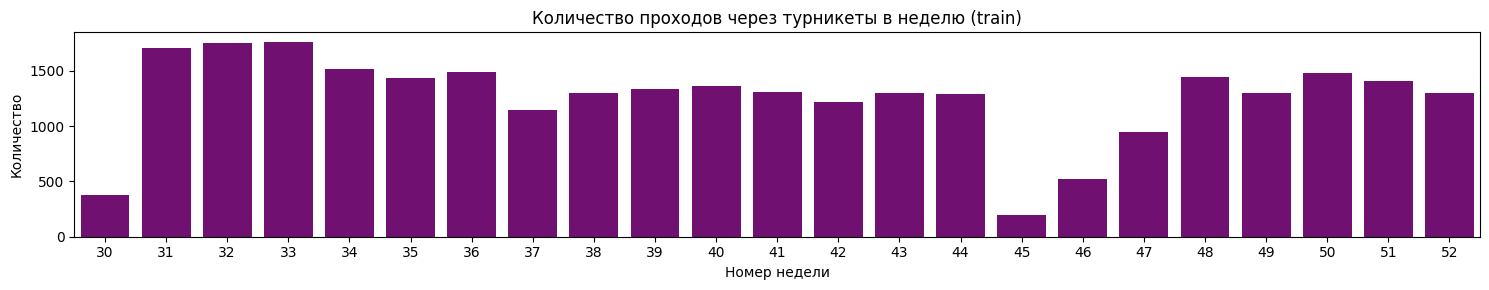

In [45]:
plt.figure(figsize=(15, 3))
sns.barplot(x='week_number', y='count', data=week_counts_train, color='purple')
plt.title('Количество проходов через турникеты в неделю (train)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [46]:
df_train.loc[df_train['week_number'] == 30, 'date'].nunique()

3

In [47]:
df_train.loc[df_train['week_number'] == 45, 'date'].nunique()

3

Мы видим, что 30 неделя - неполная. Поскольку при генерировании признаков мы использовали агрегацию по номеру недели, удалим данные за 30 неделю из тренировочной выборки.

In [48]:
df_train.shape

(28863, 73)

In [49]:
# df_train = df_train.query('week_number > 30 and week_number != 45').reset_index(drop=True)
# df_train.shape

In [50]:
df_train = df_train.query('week_number > 30').reset_index(drop=True)
df_train.shape

(28490, 73)

In [51]:
df_train['user_id'].nunique()

35

In [52]:
week_counts_test = df_test['week_number'].value_counts().sort_index().reset_index()

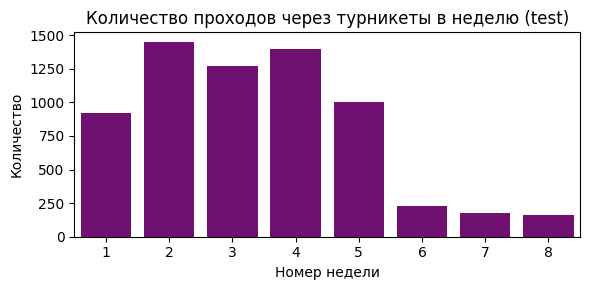

In [53]:
plt.figure(figsize=(6, 3))
sns.barplot(x='week_number', y='count', data=week_counts_test, color='purple')
plt.title('Количество проходов через турникеты в неделю (test)')
plt.xlabel('Номер недели')
plt.ylabel('Количество')
plt.tight_layout()

In [54]:
df_test.loc[df_test['week_number'] == 1, 'date'].nunique()

5

In [55]:
df_test.loc[df_test['week_number'] == 8, 'date'].nunique()

5

Удалим из тестовой выборки данные с 6 по 8 неделю, поскольку в этот период была маленькая активность.

In [56]:
df_test.shape

(6612, 73)

In [57]:
# df_test = df_test.query('week_number < 6').reset_index(drop=True)
# df_test.shape

In [58]:
df_test['user_id'].nunique()

34

In [59]:
df_train = df_train.sort_values('ts').reset_index(drop=True)
df_test = df_test.sort_values('ts').reset_index(drop=True)

In [60]:
# удаление вспомогательных признаков
df_train = df_train.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)
df_test = df_test.drop(['ts', 'date', 'week_number', 'exit_time', 'temp_sec_btw_lag_1'], axis=1)

In [61]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28490 entries, 0 to 28489
Data columns (total 68 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   user_id                               28490 non-null  int64  
 1   gate_id                               28490 non-null  int64  
 2   day_of_month                          28490 non-null  int32  
 3   hour                                  28490 non-null  int32  
 4   total_minutes                         28490 non-null  int32  
 5   total_seconds                         28490 non-null  int32  
 6   day_of_week                           28490 non-null  int32  
 7   is_weekend                            28490 non-null  bool   
 8   time_of_day                           28490 non-null  object 
 9   is_month_start                        28490 non-null  bool   
 10  is_month_end                          28490 non-null  bool   
 11  pass_cnt_per_da

In [62]:
df_train.columns

Index(['user_id', 'gate_id', 'day_of_month', 'hour', 'total_minutes',
       'total_seconds', 'day_of_week', 'is_weekend', 'time_of_day',
       'is_month_start', 'is_month_end', 'pass_cnt_per_day',
       'daily_gate_pass_count', 'probability_gate_id', 'cnt_users_per_day',
       'cnt_users_per_week', 'daily_attendance_index', 'cnt_days_per_week',
       'nunique_gate_per_day', 'nunique_gate_per_week', 'entry_time',
       'working_time_per_day', 'entrance_gate_id', 'exit_gate_id',
       'working_time_per_week', 'daily_workload_index', 'gate_id_lag_1',
       'gate_id_1', 'sec_btw_lag_1', 'sec_btw_1', 'gate_id_lag_2', 'gate_id_2',
       'sec_btw_lag_2', 'sec_btw_2', 'gate_id_lag_3', 'gate_id_3',
       'sec_btw_lag_3', 'sec_btw_3', 'gate_id_lag_4', 'gate_id_4',
       'sec_btw_lag_4', 'sec_btw_4', 'gate_id_lag_5', 'gate_id_5',
       'sec_btw_lag_5', 'sec_btw_5', 'repeat_gate_1s', 'repeat_gate_2s',
       'repeat_gate_3s', 'repeat_gate_4s', 'repeat_gate_ge_5s',
       'cnt_repeat_ga

In [63]:
categorical_features = [
       'gate_id', 'day_of_month', 'hour',
       'day_of_week', 'is_weekend', 'time_of_day', 
       'is_month_start', 'is_month_end', 'entrance_gate_id', 
       'exit_gate_id', 'gate_id_lag_1', 'gate_id_1',
       'gate_id_lag_2', 'gate_id_2', 'gate_id_lag_3',
       'gate_id_3', 'gate_id_lag_4', 'gate_id_4',
       'gate_id_lag_5', 'gate_id_5', 'repeat_gate_1s',
       'repeat_gate_2s', 'repeat_gate_3s', 'repeat_gate_4s',
       'repeat_gate_ge_5s', 'route', 'most_frequent_gate_per_day',
       'most_frequent_gate_per_week', 'most_frequent_route_per_day', 'most_frequent_route_per_week',
       'most_frequent_entrance_gate_per_week', 'most_frequent_exit_gate_per_week'
]

## Оценка важности признаков

### Корреляция между признаками

In [64]:
# %%time
# phik_overview = df_train.phik_matrix().round(2).sort_values('user_id', ascending=False)
# phik_overview

In [65]:
# # отберем фичи, у которых корреляция с целевым признаком более 0.2
# df_train = df_train[phik_overview[phik_overview['user_id'] > 0.2].index]

In [66]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(phik_overview, vmin=0, vmax=1, cmap='Purples', annot=True, linewidths=0.1, fmt='.2f')
# plt.suptitle('Матрица Phi_K-корреляций', y=0.92);

In [67]:
# %%time
# significance_overview = df_train.significance_matrix().fillna(0).round(1).sort_values('user_id', ascending=False)
# significance_overview

In [68]:
# fig = plt.figure(figsize=(45,15))
# sns.heatmap(significance_overview, vmin=-5, vmax=5, cmap='Purples', annot=True, linewidths=0.1, fmt='.1f')
# plt.suptitle('Значимость коэффициентов', y=0.92);

# Построение моделей

## Разделение исходных данных на выборки

In [69]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28490 entries, 0 to 28489
Data columns (total 68 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   user_id                               28490 non-null  int64  
 1   gate_id                               28490 non-null  int64  
 2   day_of_month                          28490 non-null  int32  
 3   hour                                  28490 non-null  int32  
 4   total_minutes                         28490 non-null  int32  
 5   total_seconds                         28490 non-null  int32  
 6   day_of_week                           28490 non-null  int32  
 7   is_weekend                            28490 non-null  bool   
 8   time_of_day                           28490 non-null  object 
 9   is_month_start                        28490 non-null  bool   
 10  is_month_end                          28490 non-null  bool   
 11  pass_cnt_per_da

In [70]:
y = df_train['user_id']
X = df_train.drop(['user_id'], axis=1)

In [71]:
# categorical_columns = categorical_features
# print(categorical_columns)

In [72]:
# len(categorical_columns)

In [73]:
# numerical_columns = list(set(X.columns) - set(categorical_columns))
# print(numerical_columns)

In [74]:
# len(numerical_columns)

In [75]:
# X = X[categorical_columns + numerical_columns]

In [76]:
# # формируем массив индексов категориальных признаков
# categorical_features_indices = np.where(X.dtypes == 'category')[0]
# categorical_features_indices

In [77]:
# # формируем массив индексов категориальных признаков
# categorical_features_indices = list(range(len(categorical_columns)))
# print(categorical_features_indices)

In [78]:
# выделение обучающей выборки (80 %) и тестовой (20 %)
X_train, X_test, y_train, y_test = train_test_split(
                                                    X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y
)

In [79]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22792, 67), (5698, 67), (22792,), (5698,))

In [80]:
y_train.nunique()

35

In [81]:
print(sorted(y_train.unique()))

[0, 1, 2, 3, 6, 8, 9, 11, 12, 14, 15, 17, 19, 22, 23, 24, 25, 26, 27, 29, 32, 33, 34, 35, 36, 37, 39, 41, 43, 46, 49, 50, 54, 55, 56]


In [82]:
y_test.nunique()

35

In [83]:
print(sorted(y_test.unique()))

[0, 1, 2, 3, 6, 8, 9, 11, 12, 14, 15, 17, 19, 22, 23, 24, 25, 26, 27, 29, 32, 33, 34, 35, 36, 37, 39, 41, 43, 46, 49, 50, 54, 55, 56]


## Подбор гиперпараметров

In [84]:
def fit_catboost(trial, train, val, cat_features_indices):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'n_estimators' : 2000, # Можно не перебирать, есть Early-Stopping
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3.0, 60.0),        
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', ['Balanced', 'None']),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'border_count': trial.suggest_int('border_count', 32, 128)
    }

    clf = CatBoostClassifier(
        **param,
        loss_function='MultiClass',
        eval_metric='TotalF1:average=Macro',
        random_seed=RANDOM_STATE,
        cat_features=cat_features_indices,
        thread_count=-1,
        task_type='GPU',
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=100,
        plot=False,
        early_stopping_rounds=100,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [85]:
def objective(trial, X, y, cat_features_indices, return_models=False):
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    scores, models = [], []
    
    for train_idx, valid_idx in skf.split(X, y):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_catboost(trial, train_data, valid_data, cat_features_indices) # Определили выше
        scores.append(f1_score(valid_data[1], y_pred, average='macro'))
        models.append(model)
         

    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result

In [86]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X, y, categorical_features),
                n_trials=3,
                show_progress_bar=True,
)

[I 2024-08-16 14:18:07,212] A new study created in memory with name: no-name-73681624-93cd-40cc-b2f0-a5f8bcc57114


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.1995064	test: 0.2058814	best: 0.2058814 (0)	total: 46.1ms	remaining: 1m 32s
100:	learn: 0.8283260	test: 0.8269430	best: 0.8288056 (99)	total: 4.25s	remaining: 1m 19s
200:	learn: 0.8983680	test: 0.8911531	best: 0.8911531 (200)	total: 8.24s	remaining: 1m 13s
300:	learn: 0.9298635	test: 0.9232028	best: 0.9234687 (295)	total: 12.1s	remaining: 1m 8s
400:	learn: 0.9508799	test: 0.9433375	best: 0.9433375 (400)	total: 16s	remaining: 1m 3s
500:	learn: 0.9634937	test: 0.9571985	best: 0.9572479 (498)	total: 19.9s	remaining: 59.5s
600:	learn: 0.9710818	test: 0.9674571	best: 0.9674571 (600)	total: 23.7s	remaining: 55.2s
700:	learn: 0.9775241	test: 0.9742068	best: 0.9742068 (700)	total: 27.6s	remaining: 51.2s
800:	learn: 0.9829600	test: 0.9803635	best: 0.9803635 (800)	total: 31.5s	remaining: 47.1s
900:	learn: 0.9855000	test: 0.9826988	best: 0.9826988 (899)	total: 35.2s	remaining: 43s
1000:	learn: 0.9867899	test: 0.9842312	best: 0.9842312 (1000)	total: 38.9s	remaining: 38.9s
1100:	learn: 

In [87]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.998456213980594, params {'learning_rate': 0.05328466110887766, 'l2_leaf_reg': 17.73969853470537, 'auto_class_weights': 'None', 'max_depth': 9, 'border_count': 109}


In [88]:
%%time

valid_scores, models_all_features = objective(
    optuna.trial.FixedTrial(study.best_params),
    X, 
    y, 
    categorical_features,
    return_models=True,
)

0:	learn: 0.3824798	test: 0.3804157	best: 0.3804157 (0)	total: 358ms	remaining: 11m 55s
100:	learn: 0.8790799	test: 0.8564030	best: 0.8564030 (100)	total: 36.2s	remaining: 11m 21s
200:	learn: 0.9710020	test: 0.9525076	best: 0.9527333 (195)	total: 1m 10s	remaining: 10m 26s
300:	learn: 0.9907792	test: 0.9860582	best: 0.9860582 (299)	total: 1m 41s	remaining: 9m 32s
400:	learn: 0.9954299	test: 0.9945534	best: 0.9946387 (395)	total: 2m 12s	remaining: 8m 48s
500:	learn: 0.9979068	test: 0.9973341	best: 0.9975718 (499)	total: 2m 42s	remaining: 8m 6s
600:	learn: 0.9985506	test: 0.9982309	best: 0.9982309 (600)	total: 3m 11s	remaining: 7m 25s
700:	learn: 0.9992201	test: 0.9989104	best: 0.9989104 (698)	total: 3m 39s	remaining: 6m 46s
800:	learn: 0.9998911	test: 0.9994411	best: 0.9994411 (772)	total: 4m 8s	remaining: 6m 11s
900:	learn: 0.9999141	test: 0.9998281	best: 0.9998281 (880)	total: 4m 35s	remaining: 5m 36s
bestTest = 0.999828065
bestIteration = 880
Shrink model to first 881 iterations.
0:	l

In [89]:
models_all_features

In [90]:
valid_scores

0.998456213980594

In [91]:
for m in models_all_features:
    print(m.tree_count_)

881
549
1168


In [92]:
for m in models_all_features:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 2000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 17.73969841003418, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage

## Важность признаков

### Feature Importance

In [93]:
# models_all_features[1].get_feature_importance(prettified=True)

In [ ]:
# feature_importance = models_all_features[1].feature_importances_
# sorted_idx = np.argsort(feature_importance)

In [ ]:
# plt.figure(figsize=(15, 15))
# plt.barh(np.array(X.columns)[sorted_idx], feature_importance[sorted_idx], color='skyblue')
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.title('Feature Importance in CatBoostClassifier')
# plt.grid(axis='x', linestyle='--', linewidth=0.7)

### SHAP values

## Отбор признаков

In [ ]:
# создаем список имен признаков
feature_names = list(X_train.columns)

# создаем обучающий и проверочный пулы
train_pool = Pool(X_train, 
                  y_train,
                  feature_names=feature_names, 
                  cat_features=categorical_features)

test_pool = Pool(X_test, 
                 y_test, 
                 feature_names=feature_names, 
                 cat_features=categorical_features)

In [ ]:
study.best_params

{'learning_rate': 0.04297364008773572,
 'l2_leaf_reg': 11.65131039758567,
 'auto_class_weights': 'None',
 'max_depth': 9,
 'border_count': 36}

In [ ]:
# пишем функцию отбора признаков на основе 
# рекурсивного удаления признаков
def catboost_select_features(
    algorithm: EFeaturesSelectionAlgorithm, 
    steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(
                    **study.best_params,
                    n_estimators=800,
                    random_seed=RANDOM_STATE,
                    loss_function='MultiClass',
                    eval_metric='TotalF1:average=Macro',
                    thread_count=-1,
                    task_type='GPU'
    )
    summary = model.select_features(
        # обучающий пул
        train_pool,
        # проверочный пул
        eval_set=test_pool,
        # список признаков, участвующих в отборе
        features_for_select=list(range(train_pool.num_col())),
        # количество отбираемых признаков
        num_features_to_select=3,
        # количество итераций обучения модели, вычисляющей 
        # оценки важностей (чем больше, тем лучше качество)
        steps=steps,
        # алгоритм отбора
        algorithm=algorithm,
        # метод вычисления значений SHAP
        shap_calc_type=EShapCalcType.Regular,
        # обучаем модель с отобранными признаками
        train_final_model=True,
        # уровень детализации вывода
        logging_level='Silent',
        # отрисовка кривых обучения и валидации
        plot=True
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

In [ ]:
%%time

# выполняем отбор признаков
shap_summary = catboost_select_features(
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, 
    steps=5
)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Selected features: ['working_time_per_week', 'most_frequent_gate_per_week', 'nunique_route_per_week']
CPU times: total: 2h 21min 48s
Wall time: 17min 41s


In [ ]:
print(shap_summary['loss_graph'])

{'main_indices': [0, 33, 50, 59, 64, 67], 'removed_features_count': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67], 'loss_values': [0.05893465244926891, 0.07193846279883465, 0.07193846279881795, 0.07193846279881795, 0.07193846279881795, 0.07193846279881795, 0.07193846279881795, 0.07193846279881795, 0.07193846279881795, 0.07193846279881795, 0.07193846279876787, 0.07193846279873446, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279873446, 0.07193846279873446, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279871777, 0.07193846279868438, 0.07193846279868438, 0

In [ ]:
shap_summary['loss_graph']['loss_values'][-1]

0.25807046550675605

In [ ]:
# печатаем отобранные признаки
selected_feat = shap_summary['selected_features_names']
print(selected_feat)

['working_time_per_week', 'most_frequent_gate_per_week', 'nunique_route_per_week']


In [ ]:
# печатаем исключенные признаки
eliminated_feat = shap_summary['eliminated_features_names']
print(eliminated_feat)

['sec_btw_3', 'gate_id', 'gate_id_lag_1', 'day_of_month', 'hour', 'is_weekend', 'is_month_start', 'is_month_end', 'daily_gate_pass_count', 'gate_id_1', 'gate_id_2', 'gate_id_lag_3', 'gate_id_3', 'gate_id_lag_4', 'gate_id_4', 'gate_triple_activation', 'sec_btw_4', 'route', 'cumtime_per_day', 'cumtime_at_route_per_day', 'most_frequent_route_per_day', 'weekly_route_std_time', 'gate_id_lag_5', 'gate_id_5', 'sec_btw_lag_5', 'sec_btw_5', 'repeat_gate_1s', 'repeat_gate_3s', 'repeat_gate_4s', 'repeat_gate_ge_5s', 'time_of_day', 'gate_id_lag_2', 'total_minutes', 'repeat_gate_2s', 'sec_btw_lag_1', 'most_frequent_gate_per_day', 'entrance_gate_id', 'exit_gate_id', 'sec_btw_lag_2', 'weekly_route_avg_time', 'sec_btw_2', 'sec_btw_lag_4', 'probability_gate_id', 'cnt_repeat_gate_4s', 'sec_btw_1', 'sec_btw_lag_3', 'total_seconds', 'day_of_week', 'route_std_time', 'route_avg_time', 'cnt_users_per_day', 'cnt_repeat_gate_3s', 'daily_attendance_index', 'daily_workload_index', 'cnt_repeat_gate_ge_5s', 'cnt_r

На основе графика `Loss by eliminated features`, отберем из списка `eliminated_feat` фичи, начиная с 49-го индекса.

In [ ]:
selected_features = selected_feat + eliminated_feat[49:]
selected_features

['working_time_per_week',
 'most_frequent_gate_per_week',
 'nunique_route_per_week',
 'route_avg_time',
 'cnt_users_per_day',
 'cnt_repeat_gate_3s',
 'daily_attendance_index',
 'daily_workload_index',
 'cnt_repeat_gate_ge_5s',
 'cnt_repeat_gate_2s',
 'nunique_gate_per_day',
 'pass_cnt_per_day',
 'cnt_repeat_gate_1s',
 'working_time_per_day',
 'most_frequent_entrance_gate_per_week',
 'cnt_days_per_week',
 'most_frequent_route_per_week',
 'cnt_users_per_week',
 'nunique_gate_per_week',
 'most_frequent_exit_gate_per_week',
 'entry_time']

In [ ]:
len(selected_features)

21

In [ ]:
cat_features = [
    'most_frequent_gate_per_week',
    'most_frequent_entrance_gate_per_week',
    'most_frequent_route_per_week',
    'most_frequent_exit_gate_per_week',
]

In [ ]:
%%time

valid_scores, models_selected_features = objective(
    optuna.trial.FixedTrial(study.best_params),
    X[selected_features], 
    y, 
    cat_features,
    return_models=True,
)

0:	learn: 0.4007834	test: 0.3901104	best: 0.3901104 (0)	total: 195ms	remaining: 6m 30s
100:	learn: 0.9354000	test: 0.9121491	best: 0.9121491 (100)	total: 14.7s	remaining: 4m 37s
200:	learn: 0.9837736	test: 0.9716423	best: 0.9716423 (200)	total: 28.8s	remaining: 4m 17s
300:	learn: 0.9963192	test: 0.9937391	best: 0.9937391 (296)	total: 41.5s	remaining: 3m 54s
400:	learn: 0.9986501	test: 0.9979904	best: 0.9979904 (363)	total: 53.7s	remaining: 3m 34s
500:	learn: 0.9992714	test: 0.9986876	best: 0.9986876 (474)	total: 1m 4s	remaining: 3m 13s
600:	learn: 0.9993770	test: 0.9992160	best: 0.9992160 (570)	total: 1m 14s	remaining: 2m 53s
700:	learn: 0.9993770	test: 0.9992160	best: 0.9994407 (636)	total: 1m 24s	remaining: 2m 36s
800:	learn: 0.9996186	test: 0.9997806	best: 0.9997806 (733)	total: 1m 34s	remaining: 2m 20s
bestTest = 0.9997805574
bestIteration = 733
Shrink model to first 734 iterations.
0:	learn: 0.3956776	test: 0.3906075	best: 0.3906075 (0)	total: 142ms	remaining: 4m 44s
100:	learn: 0

In [ ]:
valid_scores

0.9984895709103195

In [ ]:
for m in models_selected_features:
    print(m.tree_count_)

734
814
436


In [ ]:
for m in models_selected_features:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 2000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 11.651309967041016, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storag

## Подбор гиперпараметров после отбора признаков

In [ ]:
%%time

study = optuna.create_study(direction='maximize')
study.optimize(
                lambda trial: objective(trial, X[selected_features], y, cat_features),
                n_trials=3,
                show_progress_bar=True,
)

[I 2024-08-15 22:36:49,029] A new study created in memory with name: no-name-0bd33a55-366b-4b01-be6d-b977d4de47f9


  0%|          | 0/3 [00:00<?, ?it/s]

0:	learn: 0.3143760	test: 0.3021613	best: 0.3021613 (0)	total: 62.9ms	remaining: 2m 5s
100:	learn: 0.9398499	test: 0.9373522	best: 0.9373522 (100)	total: 4.41s	remaining: 1m 22s
200:	learn: 0.9811990	test: 0.9796056	best: 0.9796056 (200)	total: 8.44s	remaining: 1m 15s
300:	learn: 0.9906184	test: 0.9885019	best: 0.9885019 (300)	total: 12.3s	remaining: 1m 9s
400:	learn: 0.9941541	test: 0.9925621	best: 0.9925621 (398)	total: 16.1s	remaining: 1m 4s
500:	learn: 0.9954882	test: 0.9948336	best: 0.9948336 (500)	total: 19.7s	remaining: 58.9s
600:	learn: 0.9968709	test: 0.9959297	best: 0.9959297 (600)	total: 23.3s	remaining: 54.2s
700:	learn: 0.9975384	test: 0.9969681	best: 0.9970777 (696)	total: 26.8s	remaining: 49.7s
800:	learn: 0.9979513	test: 0.9974755	best: 0.9974755 (770)	total: 30.3s	remaining: 45.4s
900:	learn: 0.9981296	test: 0.9979155	best: 0.9979155 (900)	total: 34s	remaining: 41.5s
1000:	learn: 0.9988398	test: 0.9982114	best: 0.9984165 (985)	total: 37.6s	remaining: 37.5s
1100:	learn:

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.9994068637923018, params {'learning_rate': 0.08699429997044715, 'l2_leaf_reg': 6.994157555716834, 'auto_class_weights': 'Balanced', 'max_depth': 8, 'border_count': 111}


In [ ]:
%%time

valid_scores, models_sf_new_fit = objective(
    optuna.trial.FixedTrial(study.best_params),
    X[selected_features], 
    y, 
    cat_features,
    return_models=True,
)

0:	learn: 0.4308180	test: 0.4169848	best: 0.4169848 (0)	total: 135ms	remaining: 4m 30s
100:	learn: 0.9945462	test: 0.9945670	best: 0.9945670 (100)	total: 8.95s	remaining: 2m 48s
200:	learn: 0.9996840	test: 1.0000000	best: 1.0000000 (198)	total: 16.1s	remaining: 2m 24s
bestTest = 1
bestIteration = 198
Shrink model to first 199 iterations.
0:	learn: 0.4385372	test: 0.4372399	best: 0.4372399 (0)	total: 108ms	remaining: 3m 35s
100:	learn: 0.9959685	test: 0.9948369	best: 0.9949483 (99)	total: 8.76s	remaining: 2m 44s
200:	learn: 0.9997423	test: 0.9992348	best: 0.9992348 (189)	total: 16s	remaining: 2m 23s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (213)	total: 23s	remaining: 2m 9s
bestTest = 1
bestIteration = 213
Shrink model to first 214 iterations.
0:	learn: 0.4539735	test: 0.4390737	best: 0.4390737 (0)	total: 105ms	remaining: 3m 30s
100:	learn: 0.9954335	test: 0.9941160	best: 0.9941160 (99)	total: 8.62s	remaining: 2m 42s
200:	learn: 0.9997898	test: 0.9983037	best: 0.9983037 (194

In [ ]:
valid_scores

0.9994068637923018

In [ ]:
for m in models_sf_new_fit:
    print(m.tree_count_)

199
214
265


In [ ]:
for m in models_sf_new_fit:
    print(m.get_all_params())

{'nan_mode': 'Min', 'gpu_ram_part': 0.95, 'eval_metric': 'TotalF1:average=Macro', 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1', 'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'], 'iterations': 2000, 'fold_permutation_block': 64, 'leaf_estimation_method': 'Newton', 'observations_to_bootstrap': 'TestOnly', 'od_pval': 0, 'random_score_type': 'NormalWithModelSizeDecrease', 'counter_calc_method': 'SkipTest', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'ctr_history_unit': 'Sample', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'one_hot_max_size': 2, 'devices': '-1', 'eval_fraction': 0, 'pinned_memory_bytes': '104857600', 'force_unit_auto_pair_weights': False, 'l2_leaf_reg': 6.994157791137695, 'random_strength': 1, 'od_type': 'Iter', 'rsm': 1, 'boost_from_average': False, 'gpu_cat_features_storage

## Итоговое предсказание лучшей модели

In [93]:
def make_prediction_dict(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    result = result.groupby('user_word')['pred_user_id'].agg(lambda group: dict(group.value_counts())).to_dict()
    return result

In [94]:
def make_prediction(df_test, name_columns, models):
    # из тестового набора выделяем фичи, на которых обучались
    X = df_test.loc[:, name_columns]
    # датафрейм с закодированными user_id из тестовой выборки
    result = df_test.loc[:, ['user_word']]
    # делаем предсказания user_id
    predictions = np.array([model.predict(X) for model in models])
    result['pred_user_id'] = mode(predictions, axis=0)[0].flatten()
    # датафрейм: user_word; предсказанный user_id; количество предсказанных конкретных user_id для конкретной категории user_word
    temp_1 = result.groupby(['user_word', 'pred_user_id']).size().reset_index(name='count_pred_user_id_in_user_word')
    # датафрейм: user_word; количество user_word
    temp_2 = result['user_word'].value_counts().reset_index(name='count_user_word')
    # датафрейм: pred_user_id; количество pred_user_id
    temp_3 = result['pred_user_id'].value_counts().reset_index(name='count_pred_user_id')
    # датафрейм: user_word; pred_user_id; count_pred_user_id_in_user_word; count_user_word; count_pred_user_id
    result = temp_1.merge(temp_2, on='user_word', how='left').merge(temp_3, on='pred_user_id', how='left')
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во user_word
    result['confidence_per_user_word'] = result['count_pred_user_id_in_user_word'] / result['count_user_word']
    # добавляем уверенность модели в том, что предсказанный user_id, соответсвует user_word, в знаменателе - кол-во pred_user_id
    result['confidence_per_pred_user_id'] = result['count_pred_user_id_in_user_word'] / result['count_pred_user_id']
    # итоговая уверенность
    result['confidence'] = result['confidence_per_user_word'] + result['confidence_per_pred_user_id']
    # сортируем данные по убыванию уверенности
    result = result.sort_values(by='confidence', ascending=False)

    # формируем итоговый датафрейм
    final = pd.DataFrame(columns=['user_word', 'preds'])
    # user_word, которые уже добавлены в final
    words = set()
    # user_id, которые уже добавлены в final
    ids = set()
    # добавляем в final предсказания по приоритету уверенности (result уже отсортирован)
    for _, row in result.iterrows():
        word, user_id = row['user_word'], row['pred_user_id']
        if word not in words and user_id not in ids and row['confidence'] > 0.1:
            final.loc[len(final)] = [word, user_id]
            words.add(word)
            ids.add(user_id)

    # категориям, насчет которых модель не уверена, проставляется -999
    for word in (set(result['user_word'].unique()) - set(final['user_word'])):
        final.loc[len(final)] = [word, -999]
    
    return final.sort_values(by='user_word')

In [95]:
df_test = df_test.rename(columns={'user_id': 'user_word'})

Сделаем предсказание

Используем все фичи

In [96]:
# delete_user_id = [2, 4, 5, 7, 8, 10, 21, 22, 28, 30, 36, 38, 44, 45, 51, 52] + [18, 20, 27, 31, 40, 41, 42, 57]

In [97]:
result_dct = make_prediction_dict(df_test, X.columns, models_all_features)
result_dct

{'aucroc': {24: 35, 49: 2},
 'binary': {12: 196, 46: 65, 14: 43, 9: 23, 15: 20, 50: 15},
 'blue': {25: 12},
 'categorical': {14: 241},
 'coefficient': {15: 21, 1: 11, 41: 9, 26: 8, 27: 7},
 'collinear': {6: 78,
  37: 54,
  43: 42,
  35: 40,
  14: 26,
  1: 17,
  29: 15,
  50: 7,
  15: 6,
  33: 5,
  39: 4,
  26: 3,
  24: 1},
 'distributed': {0: 64, 11: 26, 34: 14, 55: 13},
 'epsilon': {49: 153, 1: 113, 24: 41, 26: 14, 14: 9, 25: 6},
 'f1': {6: 660, 27: 33},
 'fit': {15: 78, 23: 54, 35: 24, 34: 14, 54: 8, 0: 5},
 'gini': {15: 188, 1: 24, 54: 17, 3: 9, 0: 8, 49: 6},
 'independent': {49: 114, 15: 60, 14: 44, 1: 28, 46: 14, 24: 12, 25: 6},
 'lasso': {25: 14, 34: 10, 56: 9},
 'linear': {0: 92, 17: 67, 3: 25, 19: 15},
 'logistic': {56: 5},
 'loss': {19: 330, 15: 62, 37: 33, 12: 22, 14: 11},
 'matrix': {29: 44,
  50: 30,
  54: 17,
  14: 16,
  27: 16,
  11: 14,
  9: 9,
  39: 7,
  43: 4},
 'minimization': {50: 59, 29: 21, 34: 11, 25: 4},
 'mse': {43: 52, 23: 26, 50: 14, 34: 7, 56: 4},
 'ols': {11

In [98]:
result_cb = make_prediction(df_test, X.columns, models_all_features)
result_cb

,user_word,preds
8,aucroc,24
11,binary,12
12,blue,25
4,categorical,14
10,coefficient,41
21,collinear,37
22,distributed,0
19,epsilon,49
1,f1,6
23,fit,23


In [ ]:
len(result_cb)

34

После удаления фичей, уменьшающих скор

In [ ]:
result_dct_sf = make_prediction_dict(df_test, selected_features, models_selected_features)
result_dct_sf

{'aucroc': {24: 35},
 'binary': {12: 234, 46: 34, 9: 33, 14: 25, 56: 3},
 'blue': {25: 12},
 'categorical': {14: 171},
 'coefficient': {15: 24, 26: 16, 43: 9, 14: 7},
 'collinear': {6: 77, 37: 55, 35: 42, 43: 35, 24: 18, 33: 17, 54: 6, 1: 2},
 'distributed': {0: 66, 55: 25, 34: 14, 12: 12},
 'epsilon': {49: 138, 1: 113, 24: 31, 26: 14, 39: 7},
 'f1': {6: 633},
 'fit': {15: 78, 23: 47, 35: 24, 34: 14, 54: 8, 50: 7, 32: 3, 0: 2},
 'gini': {15: 178, 34: 8},
 'independent': {49: 110, 15: 60, 14: 35, 46: 14, 1: 9, 25: 6},
 'lasso': {25: 12, 34: 10, 56: 9, 46: 2},
 'linear': {17: 73, 0: 73, 3: 19, 19: 15, 33: 13, 37: 6},
 'logistic': {56: 5},
 'loss': {19: 157, 6: 95, 15: 83, 12: 39, 37: 33, 0: 18, 11: 9, 46: 7, 9: 6},
 'matrix': {33: 30, 43: 26, 11: 23, 50: 21, 29: 13, 2: 8, 23: 7, 19: 4},
 'minimization': {0: 59, 43: 32, 25: 4},
 'mse': {43: 52, 23: 26, 34: 7, 56: 4},
 'ols': {11: 99, 35: 16, 54: 16, 34: 8},
 'precision': {46: 38},
 'predict': {15: 51,
  0: 44,
  39: 29,
  37: 21,
  29: 17

In [ ]:
result_cb_sf = make_prediction(df_test, selected_features, models_selected_features)
result_cb_sf

,user_word,preds
7,aucroc,24
9,binary,12
13,blue,25
1,categorical,14
26,coefficient,26
25,collinear,35
30,distributed,-999
18,epsilon,1
2,f1,6
24,fit,23


In [ ]:
len(result_cb_sf)

34

После удаления фичей, уменьшающих скор, и повторного подбора гиперпараметров

In [ ]:
result_dct_sf_new_fit = make_prediction_dict(df_test, selected_features, models_sf_new_fit)
result_dct_sf_new_fit

{'aucroc': {24: 26, 41: 9},
 'binary': {12: 219, 46: 49, 14: 25, 9: 20, 56: 16},
 'blue': {56: 7, 25: 5},
 'categorical': {14: 171},
 'coefficient': {15: 23, 34: 16, 41: 9, 14: 7, 1: 1},
 'collinear': {37: 54,
  6: 53,
  43: 35,
  29: 30,
  33: 29,
  35: 24,
  1: 17,
  54: 7,
  0: 3},
 'distributed': {0: 89, 34: 14, 55: 14},
 'epsilon': {49: 145, 1: 123, 26: 15, 24: 14, 39: 6},
 'f1': {6: 633},
 'fit': {15: 66, 23: 46, 35: 24, 34: 16, 3: 12, 24: 8, 11: 6, 50: 5},
 'gini': {15: 170, 49: 8, 0: 8},
 'independent': {49: 67, 15: 60, 1: 52, 14: 35, 26: 14, 43: 6},
 'lasso': {25: 14, 34: 10, 56: 9},
 'linear': {0: 86, 3: 51, 17: 45, 19: 9, 33: 8},
 'logistic': {56: 5},
 'loss': {19: 392, 12: 55},
 'matrix': {2: 31, 50: 27, 43: 24, 33: 22, 29: 21, 23: 7},
 'minimization': {0: 40, 50: 28, 43: 22, 25: 5},
 'mse': {43: 52, 23: 26, 34: 7, 56: 4},
 'ols': {11: 99, 54: 26, 34: 8, 35: 6},
 'precision': {46: 38},
 'predict': {55: 42, 39: 40, 15: 26, 0: 24, 23: 21, 46: 20, 29: 18, 6: 1},
 'pvalue': {50

In [ ]:
result_cb_sf_new_fit = make_prediction(df_test, selected_features, models_sf_new_fit)
result_cb_sf_new_fit

,user_word,preds
10,aucroc,24
9,binary,12
33,blue,-999
2,categorical,14
28,coefficient,34
13,collinear,37
16,distributed,0
17,epsilon,1
1,f1,6
25,fit,23


In [ ]:
len(result_cb_sf_new_fit)

34

Сохраненим результаты

In [ ]:
csv_buffer = io.StringIO()

# result_cb.to_csv(csv_buffer, index=False)

# result_cb_sf.to_csv(csv_buffer, index=False)

# result_cb_sf_new_fit.to_csv(csv_buffer, index=False)

with zipfile.ZipFile('../data/answer.zip', mode='w', compression=zipfile.ZIP_DEFLATED) as zf:
    zf.writestr('answer.csv', csv_buffer.getvalue())

In [99]:
result_cb.to_csv('../data/submit_cb_v_07_all.csv', index=False)

# result_cb_sf.to_csv('../data/submit_cb_v_07_sf.csv', index=False)

# result_cb_sf_new_fit.to_csv('../data/submit_cb_v_05_sf_new_fit.csv', index=False)

# Сравнение ответов

In [100]:
right_answers = pd.read_csv(r'E:\projects\SHIFT\предыдущие_наработки\right_answers.csv')
res_ivan = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\1) 04_02_2024\answer_ivan.csv')
res_vera = pd.read_csv(r'E:\projects\SHIFT\От_Ивана\ШИФТ тест\Решения\4) Ivanova_Vera_SaintPetersburg 358\shift_ml-main\answer_vera.csv')
res_cb_01 = pd.read_csv('../data/submit_cb_v_01_264.csv')
res_cb_02 = pd.read_csv('../data/submit_cb_v_02.csv')
res_cb_03 = pd.read_csv('../data/submit_cb_v_03_270.csv')
res_cb_04 = pd.read_csv('../data/submit_cb_v_04.csv')
res_cb_05_all = pd.read_csv('../data/submit_cb_v_05_all_353.csv')
res_cb_05_sf = pd.read_csv('../data/submit_cb_v_05_sf.csv')
res_cb_05_sf_new_fit = pd.read_csv('../data/submit_cb_v_05_sf_new_fit_374.csv')

res_cb_07_all = pd.read_csv('../data/submit_cb_v_07_all.csv')
# res_cb_07_sf = pd.read_csv('../data/submit_cb_v_07_sf.csv')

In [101]:
res = right_answers.loc[:].rename(columns={'preds': 'right_answers'})
res['right_answers'] = res['right_answers'].apply(lambda x: f'{x:.0f}')
res['ivan'] = res_ivan['preds']
res['vera'] = res_vera['preds']
res['cb_v_01_264'] = res_cb_01['preds']
res['cb_v_02'] = res_cb_02['preds']
res['cb_v_03_270'] = res_cb_03['preds']
res['cb_v_04'] = res_cb_04['preds']
res['cb_v_05_all_353'] = res_cb_05_all['preds']
res['cb_v_05_sf'] = res_cb_05_sf['preds']
res['cb_v_05_sf_new_fit_374'] = res_cb_05_sf_new_fit['preds']

res['cb_v_07_all'] = res_cb_07_all['preds']
# res['cb_v_07_sf'] = res_cb_07_sf['preds']

In [102]:
# Функция для условного форматирования
def highlight_matching_cells(x):
    ref_col = x['vera']
    df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
    for col in x.columns:
        if col == 'right_answers':
            df_styled[col] = ['background-color: red' if x[col].iloc[i] != 'nan' else '' for i in range(len(x))]
        elif col != 'vera':
            df_styled[col] = ['background-color: green' if x[col].iloc[i] == ref_col.iloc[i] else '' for i in range(len(x))]
    return df_styled

# Применение стиля
res.style.apply(highlight_matching_cells, axis=None)

,user_word,right_answers,ivan,vera,cb_v_01_264,cb_v_02,cb_v_03_270,cb_v_04,cb_v_05_all_353,cb_v_05_sf,cb_v_05_sf_new_fit_374,cb_v_07_all
0,aucroc,24,24,24,24,49,24,24,24,24,24,24
1,binary,12,12,12,12,12,12,-999,12,12,12,12
2,blue,nan,-999,56,-999,-999,-999,-999,56,56,56,56
3,categorical,14,14,14,14,14,14,14,14,14,14,14
4,coefficient,nan,-999,27,22,22,22,26,22,22,-999,-999
5,collinear,nan,-999,23,-999,-999,47,-999,33,33,22,37
6,distributed,0,0,0,0,35,0,0,0,0,0,34
7,epsilon,1,1,1,1,1,1,49,1,1,1,49
8,f1,6,6,18,37,6,6,37,6,6,6,6
9,fit,nan,23,6,-999,23,37,23,2,2,2,23


# The end